In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import catboost as cb
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

pd.set_option('display.max_columns', 100)

In [2]:
# Load datasets
train = pd.read_csv('../data/raw/train.csv', )
test = pd.read_csv('../data/raw/test.csv', )

### Dataset information

| Column Name             | Type         | Description |
|-------------------------|--------------|-------------|
| **age**                 | Numeric      | Age of the policyholder in years. Likely influences health risk and insurance pricing. |
| **gender**              | Categorical  | Gender of the policyholder, typically `"Male"` or `"Female"`. May correlate with health or lifestyle behaviors. |
| **annual_income**       | Numeric      | The yearly income of the policyholder. Higher income may be associated with higher coverage and premium levels. |
| **marital_status**      | Categorical  | Indicates whether the policyholder is `"Single"`, `"Married"`, `"Divorced"`, etc. Can affect claim probability and policy type. |
| **number_of_dependents**| Numeric      | Number of dependents (e.g., children or family members). May influence policy size and premium. |
| **education_level**     | Categorical  | Highest level of education achieved (e.g., `"High School"`, `"Bachelor"`, `"PhD"`). Can be a proxy for socio-economic status. |
| **occupation**          | Categorical  | Job title or employment category of the policyholder. May relate to risk level (e.g., hazardous jobs). |
| **health_score**        | Numeric      | A synthetic score measuring overall health. Higher scores likely indicate better health and lower risk. |
| **location**            | Categorical  | Geographic region or ZIP-level code where the policyholder resides. Can impact risk profile and premiums. |
| **policy_type**         | Categorical  | Type of insurance policy, such as `"Basic"`, `"Standard"`, `"Premium"`, etc. Determines level of coverage. |
| **previous_claims**     | Numeric      | Number of prior insurance claims. Indicates claim history; higher values may reflect higher risk. |
| **vehicle_age**         | Numeric      | Age of the insured vehicle in years. Relevant for auto insurance policies. Older vehicles may have different premium profiles. |
| **credit_score**        | Numeric      | Creditworthiness of the policyholder. Often used in underwriting to assess reliability and risk. |
| **insurance_duration**  | Numeric      | Number of months or years the policy has been active. Longer durations may indicate loyalty and lower churn. |
| **policy_start_date**   | Date / String| The date when the insurance policy began. Useful for deriving features like policy age, seasonality, etc. |
| **customer_feedback**   | Categorical / Text | Feedback score or qualitative feedback from the customer. May reflect satisfaction or service experience. |
| **smoking_status**      | Categorical  | Indicates if the policyholder is a smoker or not. A key health risk factor affecting premiums. |
| **exercise_frequency**  | Categorical / Numeric | Frequency of exercise (e.g., `"Daily"`, `"Rarely"`, `"Never"`). Often used as a lifestyle indicator. |
| **property_type**       | Categorical  | Type of insured property (e.g., `"House"`, `"Apartment"`, `"Condo"`). Relevant for home insurance policies. |
| **premium_amount**      | Numeric (Target) | The target variable — total premium amount charged for the policy. This is what the model aims to predict. |


### Data transformation

In [3]:
# rename columns
train.columns = [str.lower(col).replace(' ','_') for col in train.columns]

In [4]:
train.head()

id   age  gender  annual_income marital_status  number_of_dependents  \
0   0  19.0  Female        10049.0        Married                   1.0   
1   1  39.0  Female        31678.0       Divorced                   3.0   
2   2  23.0    Male        25602.0       Divorced                   3.0   
3   3  21.0    Male       141855.0        Married                   2.0   
4   4  21.0    Male        39651.0         Single                   1.0   

  education_level     occupation  health_score  location    policy_type  \
0      Bachelor's  Self-Employed     22.598761     Urban        Premium   
1        Master's            NaN     15.569731     Rural  Comprehensive   
2     High School  Self-Employed     47.177549  Suburban        Premium   
3      Bachelor's            NaN     10.938144     Rural          Basic   
4      Bachelor's  Self-Employed     20.376094     Rural        Premium   

   previous_claims  vehicle_age  credit_score  insurance_duration  \
0              2.0         17.0         372.0                 5.0   
1              1.0         12.0         694.0                 2.0   
2              1.0         14.0           NaN                 3.0   
3              1.0          0.0         367.0                 1.0   
4              0.0          8.0         598.0                 4.0   

            policy_start_date customer_feedback smoking_status  \
0  2023-12-23 15:21:39.134960              Poor             No   
1  2023-06-12 15:21:39.111551           Average            Yes   
2  2023-09-30 15:21:39.221386              Good            Yes   
3  2024-06-12 15:21:39.226954              Poor            Yes   
4  2021-12-01 15:21:39.252145              Poor            Yes   

  exercise_frequency property_type  premium_amount  
0             Weekly         House          2869.0  
1            Monthly         House          1483.0  
2             Weekly         House           567.0  
3              Daily     Apartment           765.0  
4             Weekly         House          2022.0

### EDA

In [5]:
train.shape
# remove duplicated rows
train.drop_duplicates(inplace = True)
train.shape

(1200000, 21)

In [6]:
# check null value
train.isnull().sum()

id                           0
age                      18705
gender                       0
annual_income            44949
marital_status           18529
number_of_dependents    109672
education_level              0
occupation              358075
health_score             74076
location                     0
policy_type                  0
previous_claims         364029
vehicle_age                  6
credit_score            137882
insurance_duration           1
policy_start_date            0
customer_feedback        77824
smoking_status               0
exercise_frequency           0
property_type                0
premium_amount               0
dtype: int64

In [7]:
# remove null value
train.dropna(subset='premium_amount',inplace=True)

In [8]:
# remove unused columns
train.drop(columns=['id'], inplace = True)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1200000 entries, 0 to 1199999
Data columns (total 20 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   age                   1181295 non-null  float64
 1   gender                1200000 non-null  object 
 2   annual_income         1155051 non-null  float64
 3   marital_status        1181471 non-null  object 
 4   number_of_dependents  1090328 non-null  float64
 5   education_level       1200000 non-null  object 
 6   occupation            841925 non-null   object 
 7   health_score          1125924 non-null  float64
 8   location              1200000 non-null  object 
 9   policy_type           1200000 non-null  object 
 10  previous_claims       835971 non-null   float64
 11  vehicle_age           1199994 non-null  float64
 12  credit_score          1062118 non-null  float64
 13  insurance_duration    1199999 non-null  float64
 14  policy_start_date     1200000 non-

In [10]:
numerical_features = train.select_dtypes(include = 'float').columns.tolist()
numerical_features = [n for n in numerical_features if n != 'premium_amount']
categorical_features = train.select_dtypes(include = 'object').columns.tolist()
categorical_features = [n for n in categorical_features if n != 'policy_start_date']

In [11]:
numerical_features, categorical_features

(['age',
  'annual_income',
  'number_of_dependents',
  'health_score',
  'previous_claims',
  'vehicle_age',
  'credit_score',
  'insurance_duration'],
 ['gender',
  'marital_status',
  'education_level',
  'occupation',
  'location',
  'policy_type',
  'customer_feedback',
  'smoking_status',
  'exercise_frequency',
  'property_type'])

#### Plot numerical features

age
Skew : -0.01


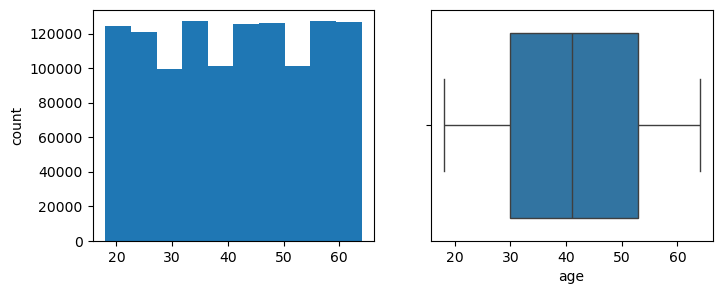

annual_income
Skew : 1.47


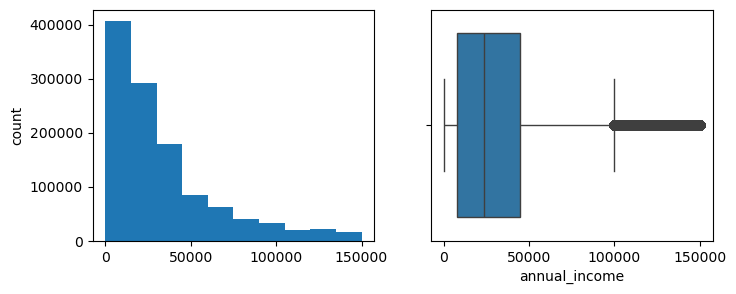

number_of_dependents
Skew : -0.01


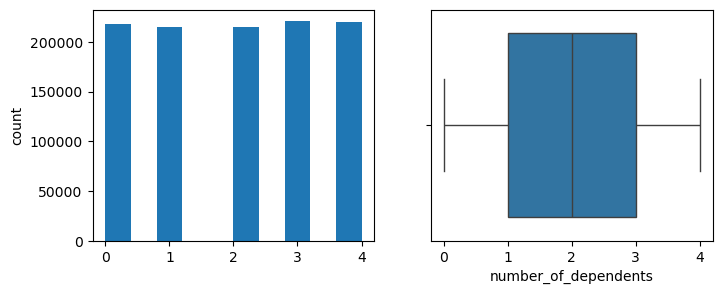

health_score
Skew : 0.28


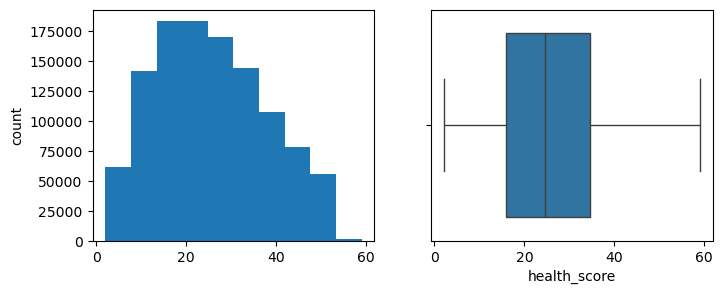

previous_claims
Skew : 0.91


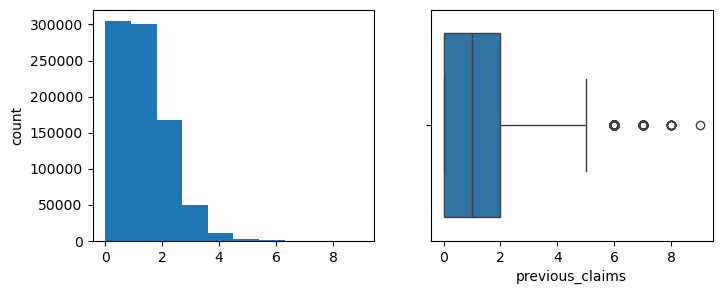

vehicle_age
Skew : -0.02


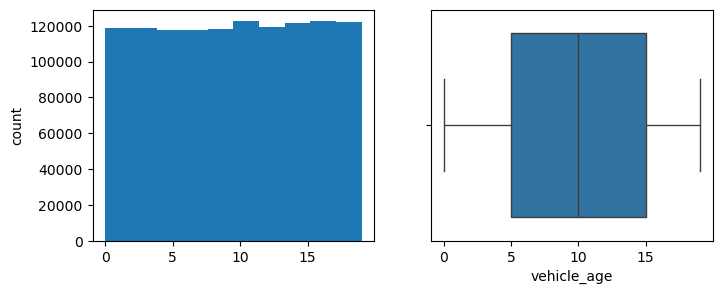

credit_score
Skew : -0.11


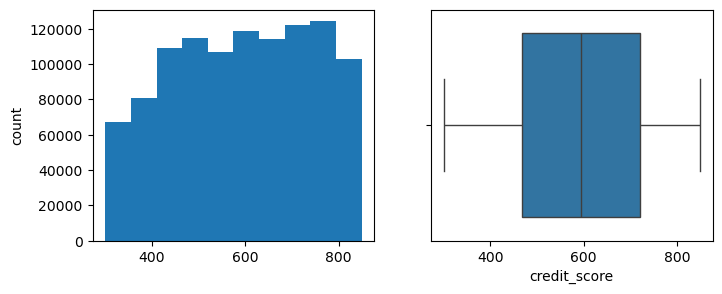

insurance_duration
Skew : -0.01


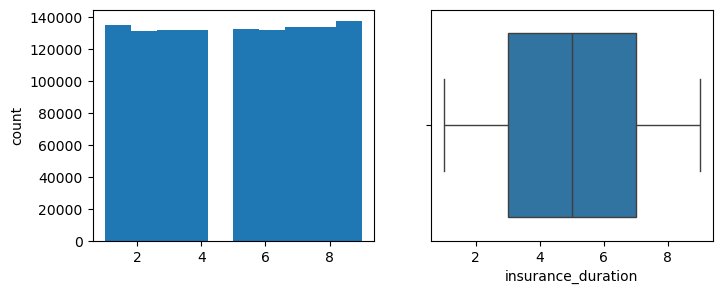

In [12]:
for col in numerical_features:
    print(col)
    print('Skew :', round(train[col].skew(), 2))
    plt.figure(figsize = (8, 3))
    plt.subplot(1, 2, 1)
    train[col].hist(grid=False, )
    plt.ylabel('count')
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train[col], )
    plt.show()


##### Multivariate analysis for numerical features

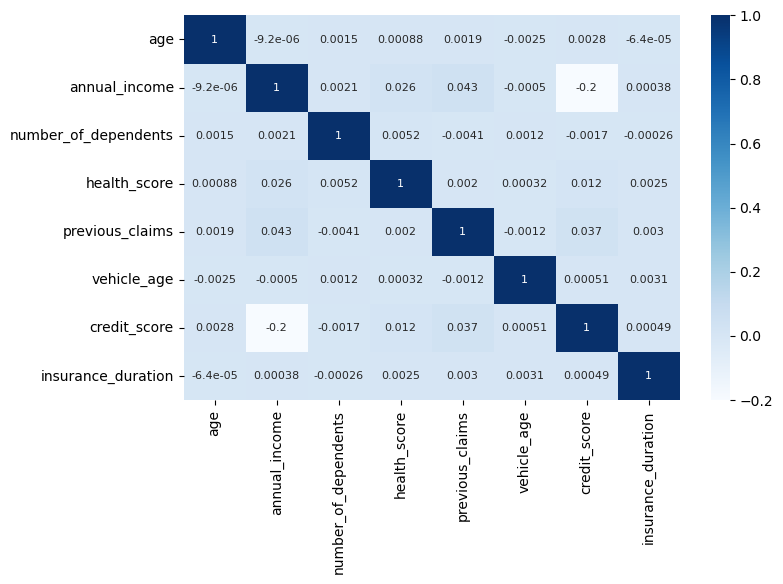

In [13]:
plt.figure(figsize = (8, 5))
sns.heatmap(train[numerical_features].corr(), cmap="Blues", annot=True, annot_kws={"fontsize":8})
plt.show()

#### Plot for categorical features

In [14]:
for col in categorical_features:
    print(col,' :', train[col].unique())

gender  : ['Female' 'Male']
marital_status  : ['Married' 'Divorced' 'Single' nan]
education_level  : ["Bachelor's" "Master's" 'High School' 'PhD']
occupation  : ['Self-Employed' nan 'Employed' 'Unemployed']
location  : ['Urban' 'Rural' 'Suburban']
policy_type  : ['Premium' 'Comprehensive' 'Basic']
customer_feedback  : ['Poor' 'Average' 'Good' nan]
smoking_status  : ['No' 'Yes']
exercise_frequency  : ['Weekly' 'Monthly' 'Daily' 'Rarely']
property_type  : ['House' 'Apartment' 'Condo']


gender


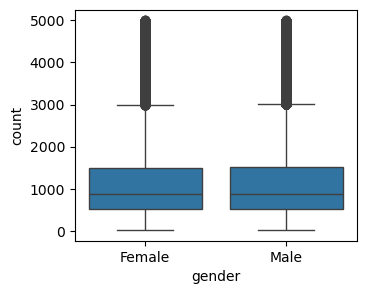

marital_status


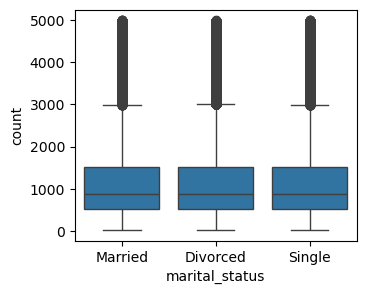

education_level


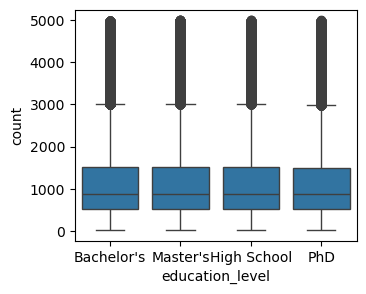

occupation


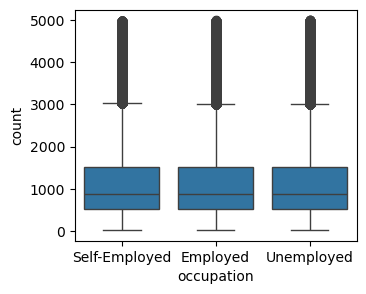

location


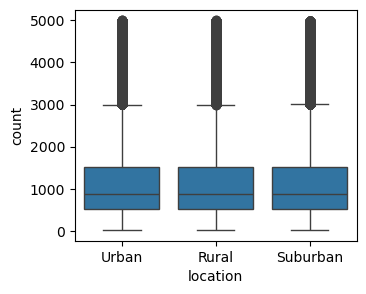

policy_type


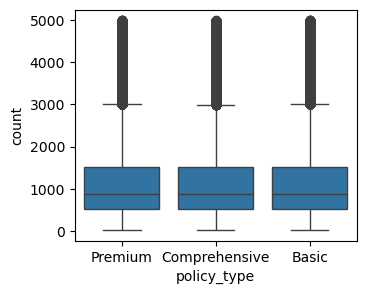

customer_feedback


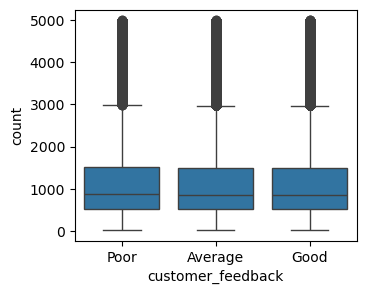

smoking_status


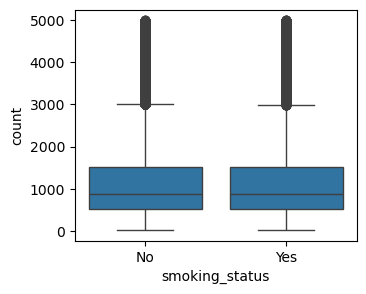

exercise_frequency


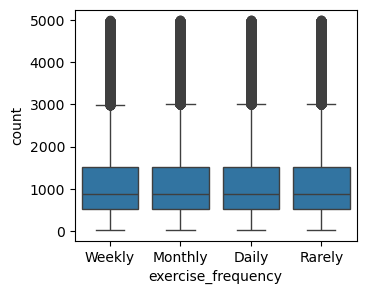

property_type


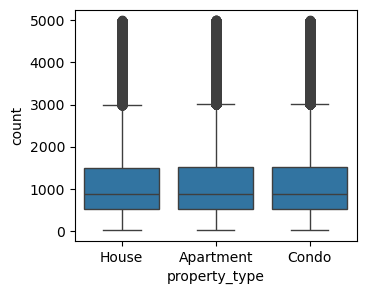

In [15]:
for col in categorical_features:
    print(col)
    plt.figure(figsize = (8, 3))
    plt.subplot(1, 2, 1)
    sns.boxplot(data=train, x=col, y='premium_amount')
    plt.ylabel('count')
    plt.show()

### Dealing with missing values

In [16]:
tdf = pd.DataFrame({
    'column name': train.columns,
    'column type': train.dtypes,
    'percentage': ((train.isnull().sum()) / train.shape[0]*100)
})
tdf.sort_values(by='percentage',ascending=False,inplace=True)
tdf

column name column type  percentage
previous_claims            previous_claims     float64   30.335750
occupation                      occupation      object   29.839583
credit_score                  credit_score     float64   11.490167
number_of_dependents  number_of_dependents     float64    9.139333
customer_feedback        customer_feedback      object    6.485333
health_score                  health_score     float64    6.173000
annual_income                annual_income     float64    3.745750
age                                    age     float64    1.558750
marital_status              marital_status      object    1.544083
vehicle_age                    vehicle_age     float64    0.000500
insurance_duration      insurance_duration     float64    0.000083
location                          location      object    0.000000
policy_type                    policy_type      object    0.000000
gender                              gender      object    0.000000
education_level            education_level      object    0.000000
policy_start_date        policy_start_date      object    0.000000
smoking_status              smoking_status      object    0.000000
exercise_frequency      exercise_frequency      object    0.000000
property_type                property_type      object    0.000000
premium_amount              premium_amount     float64    0.000000

As previous_claims and occupation have higher percentage of null value, these features will be droped.
For the remining features, missing value inputation technique will be used.

In [17]:
train.drop(columns = ['previous_claims', 'occupation'], inplace = True)

In [18]:
numerical_features = [n for n in numerical_features if n != 'previous_claims']
categorical_features = [n for n in categorical_features if n != 'occupation']

### Get features importance

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')), 
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(drop = 'first', handle_unknown='ignore'))
])

# Combine preprocessors in a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

pipeline = Pipeline([
    ('preprocessor',  preprocessor)
])

In [50]:
from sklearn.feature_selection import mutual_info_classif

X_train = train.drop(columns = ['premium_amount'])
Y_train = train['premium_amount']

pipeline.fit(X_train, Y_train)

X_train_transformed = pipeline.named_steps['preprocessor'].transform(X_train)
numerical_transformed_columns = pipeline.named_steps['preprocessor'].transformers_[0][2]
categorical_transformed_columns = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out().tolist()
all_columns = [numerical_transformed_columns + categorical_transformed_columns]
all_columns = all_columns[0]

In [51]:
all_columns = [str.lower(col).replace('\'','').replace(' ','_') for col in all_columns]

In [52]:
df_X_full_train_transformed = pd.DataFrame(
    X_train_transformed,
    columns = all_columns
)
df_X_full_train_transformed.head()

age  annual_income  number_of_dependents  health_score  vehicle_age  \
0 -1.648301      -0.707414             -0.746862     -0.249610     1.286338   
1 -0.159542      -0.023289              0.733500     -0.844110     0.420713   
2 -1.350549      -0.215473              0.733500      1.829212     0.766963   
3 -1.499425       3.461605             -0.006681     -1.235840    -1.656788   
4 -1.499425       0.228896             -0.746862     -0.437598    -0.271787   

   credit_score  insurance_duration  gender_male  marital_status_married  \
0     -1.567375           -0.007023          0.0                     1.0   
1      0.714630           -1.163391          0.0                     0.0   
2      0.013020           -0.777935          1.0                     0.0   
3     -1.602810           -1.548847          1.0                     1.0   
4      0.034281           -0.392479          1.0                     0.0   

   marital_status_single  education_level_high_school  \
0                    0.0                          0.0   
1                    0.0                          0.0   
2                    0.0                          1.0   
3                    0.0                          0.0   
4                    1.0                          0.0   

   education_level_masters  education_level_phd  location_suburban  \
0                      0.0                  0.0                0.0   
1                      1.0                  0.0                0.0   
2                      0.0                  0.0                1.0   
3                      0.0                  0.0                0.0   
4                      0.0                  0.0                0.0   

   location_urban  policy_type_comprehensive  policy_type_premium  \
0             1.0                        0.0                  1.0   
1             0.0                        1.0                  0.0   
2             0.0                        0.0                  1.0   
3             0.0                        0.0                  0.0   
4             0.0                        0.0                  1.0   

   customer_feedback_good  customer_feedback_poor  smoking_status_yes  \
0                     0.0                     1.0                 0.0   
1                     0.0                     0.0                 1.0   
2                     1.0                     0.0                 1.0   
3                     0.0                     1.0                 1.0   
4                     0.0                     1.0                 1.0   

   exercise_frequency_monthly  exercise_frequency_rarely  \
0                         0.0                        0.0   
1                         1.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        0.0   

   exercise_frequency_weekly  property_type_condo  property_type_house  
0                        1.0                  0.0                  1.0  
1                        0.0                  0.0                  1.0  
2                        1.0                  0.0                  1.0  
3                        0.0                  0.0                  0.0  
4                        1.0                  0.0                  1.0

In [55]:
from sklearn.linear_model import Ridge

# Train the model
rf = Ridge()
rf.fit(df_X_full_train_transformed, Y_train)

# Get feature importances
importances = rf.coef_

In [62]:
feature_importances = pd.DataFrame({
    'feature': all_columns,
    'importance': abs(importances)
}).sort_values(by='importance', ascending=False, inplace = False)

print(feature_importances.head(10))  # Show top 10 features

                      feature  importance
5                credit_score   23.743337
17     customer_feedback_good   15.071712
1               annual_income   13.366228
3                health_score   12.634988
18     customer_feedback_poor   12.411276
9       marital_status_single    6.227426
22  exercise_frequency_weekly    2.521511
24        property_type_house    2.447910
14             location_urban    2.271791
23        property_type_condo    2.236138


In the next section, we will work with the top 10 selected features.

In [77]:
top_features = feature_importances.head(10)['feature'].values.tolist()
top_features

['credit_score',
 'customer_feedback_good',
 'annual_income',
 'health_score',
 'customer_feedback_poor',
 'marital_status_single',
 'exercise_frequency_weekly',
 'property_type_house',
 'location_urban',
 'property_type_condo']

### Building baseline model

In [87]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error

models = {
    'LinearRegression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=0.1)
}


In [82]:
# Define evaluation metrics
def rmsle(y_true, y_pred):
    # Clip predictions to avoid log(0)
    y_pred = np.maximum(0, y_pred)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


In [81]:
X_train_part, X_validation_part, y_train_part, y_validation_part = train_test_split(df_X_full_train_transformed[top_features], Y_train, test_size=0.2, random_state=42)

In [86]:
results = {}

for name, model in models.items():
    # Create pipeline
    baseline_pipeline = Pipeline(steps=[
        ('regressor', model)
    ])

    # Train
    baseline_pipeline.fit(X_train_part, y_train_part)

    # Predict
    y_pred = baseline_pipeline.predict(X_validation_part)

    # Evaluate
    score = rmsle(y_validation_part, y_pred)
    results[name] = score

# Show results
results_df = pd.DataFrame(results.items(), columns=["Model", "RMSLE"]).sort_values(by="RMSLE")
print(results_df)


              Model     RMSLE
0  LinearRegression  1.169494
1             Ridge  1.169494
2             Lasso  1.169508


### Save prepared data

In [88]:
df_training = X_train_part.copy()
df_training['premium_amount'] = y_train_part.values  # Or just y_training_part if the index aligns

In [89]:
df_validation = X_validation_part.copy()
df_validation['premium_amount'] = y_validation_part.values  # Or just y_training_part if the index aligns

In [90]:
df_training.to_csv('../data/prepared/df_training.csv', index=False)
df_validation.to_csv('../data/prepared/df_validation.csv', index=False)

### Building baseline model with XGBoost

In [31]:
import xgboost as xgb

In [32]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

ModuleNotFoundError: No module named 'hyperopt'